In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.metrics import jaccard_score
from scipy.stats import entropy
from scipy.stats import multivariate_normal
from patsy import dmatrices
from patsy import dmatrix
from sklearn.preprocessing import LabelEncoder
from statsmodels.graphics.mosaicplot import mosaic

### Exploring Data:

In [4]:
dt = pd.read_csv('mcdonalds.csv')
# Check column names in the dataset
print(dt.columns)

Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')


In [5]:
dt.shape

(1453, 15)

In [6]:
# Printing the first three columns
dt.head(3)

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female


In [7]:
# Select columns 1 to 11 and convert 'Yes' to 1 and other values to 0
MD_x = dt.iloc[:, 0:11].apply(lambda x: (x == 'Yes').astype(int))
# Calculate column-wise means and round to 2 decimal places
means = np.round(MD_x.mean(), 2)
print(means)

yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64


In [8]:
# Fit PCA
pca = PCA()
MD_pca = pca.fit_transform(MD_x)

# Print the standard deviation of each component
print("Standard deviation:", np.round(pca.explained_variance_ ** 0.5, 5))

# Print the proportion of variance explained by each component
print("Proportion of Variance:", np.round(pca.explained_variance_ratio_, 5))

# Print the cumulative proportion of variance explained
print("Cumulative Proportion:", np.round(np.cumsum(pca.explained_variance_ratio_), 5))

Standard deviation: [0.75705 0.60746 0.50462 0.3988  0.33741 0.31027 0.2897  0.27512 0.26525
 0.24884 0.2369 ]
Proportion of Variance: [0.29945 0.1928  0.13305 0.0831  0.05948 0.0503  0.04385 0.03955 0.03676
 0.03235 0.02932]
Cumulative Proportion: [0.29945 0.49224 0.62529 0.70839 0.76787 0.81817 0.86201 0.90156 0.93832
 0.97068 1.     ]


In [9]:
# Print the standard deviations of principal components rounded to one digit
std_devs = pca.explained_variance_ ** 0.5
formatted_std_devs = [f"{std:.1f}" for std in std_devs]
print("Standard deviations:", formatted_std_devs)

Standard deviations: ['0.8', '0.6', '0.5', '0.4', '0.3', '0.3', '0.3', '0.3', '0.3', '0.2', '0.2']


In [10]:
# Assign the PCA components to a rotation matrix
rotation_matrix = pca.components_.T
rotation_matrix_new = [[round(val, 3) for val in row] for row in rotation_matrix]

# Convert the rotation matrix to a DataFrame for better display
rotation_df = pd.DataFrame(rotation_matrix_new, columns=MD_x.columns)

# Print the rotation matrix with column names
print(rotation_df)

    yummy  convenient  spicy  fattening  greasy   fast  cheap  tasty  \
0  -0.477       0.364 -0.304      0.055  -0.308  0.171 -0.281  0.013   
1  -0.155       0.016 -0.063     -0.142   0.278 -0.348 -0.060 -0.113   
2  -0.006       0.019 -0.037      0.198   0.071 -0.355  0.708  0.376   
3   0.116      -0.034 -0.322     -0.354  -0.073 -0.407 -0.386  0.590   
4   0.304      -0.064 -0.802      0.254   0.361  0.209  0.036 -0.138   
5  -0.108      -0.087 -0.065     -0.097   0.108 -0.595 -0.087 -0.628   
6  -0.337      -0.611 -0.149      0.119  -0.129 -0.103 -0.040  0.140   
7  -0.472       0.307 -0.287     -0.003  -0.211 -0.077  0.360 -0.073   
8   0.329       0.601  0.024      0.068  -0.003 -0.261 -0.068  0.030   
9  -0.214       0.077  0.192      0.763   0.288 -0.178 -0.350  0.176   
10  0.375      -0.140 -0.089      0.370  -0.729 -0.211 -0.027 -0.167   

    expensive  healthy  disgusting  
0       0.572   -0.110       0.045  
1      -0.018   -0.666      -0.542  
2       0.400   -0.076  

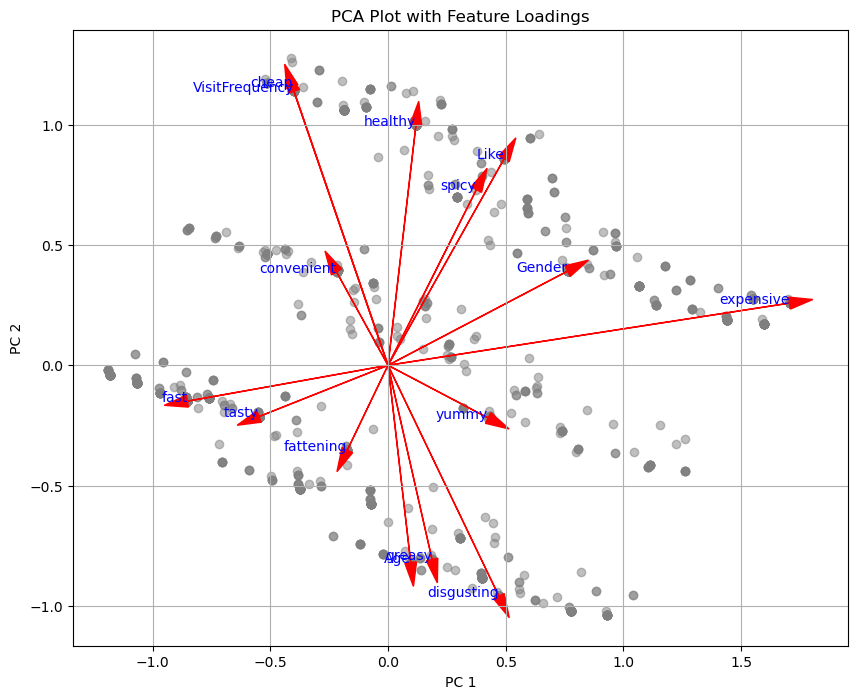

In [11]:
# Scatter plot of PCA-transformed data (PC1 vs PC2)
plt.figure(figsize=(10, 8))
plt.scatter(MD_pca[:, 0], MD_pca[:, 1], color='grey', alpha=0.5)

# Arrows for feature loadings
for i, feature in enumerate(dt.columns):
    plt.arrow(0, 0, MD_pca[i, 0], MD_pca[i, 1], color='red',
              head_width=0.05, head_length=0.1)
    plt.text(MD_pca[i, 0],MD_pca[i, 1], feature, color='blue', ha='right')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA Plot with Feature Loadings')
plt.grid()
plt.show()

### Extracting Segments

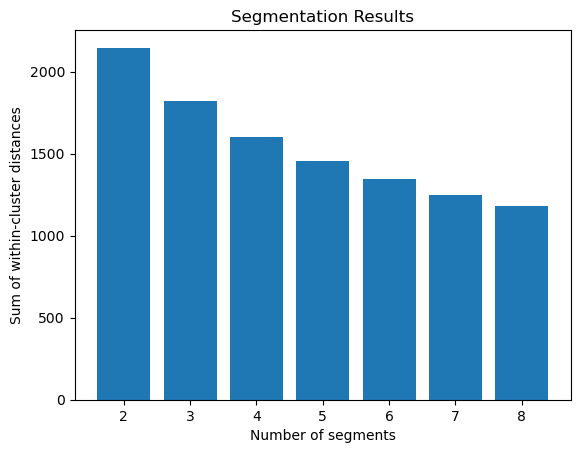

In [12]:
np.random.seed(1234)

nrep = 10

num_segments = range(2, 9)
within_cluster_distances = []
MD_km28 = {}

for k in num_segments:
    kmeans = KMeans(n_clusters=k, n_init=nrep, random_state=1234)
    kmeans.fit(MD_pca)
    within_cluster_distances.append((kmeans.inertia_))
    MD_km28[str(k)] = kmeans

plt.bar(num_segments, within_cluster_distances)
plt.xlabel("Number of segments")
plt.ylabel("Sum of within-cluster distances")
plt.title("Segmentation Results")
plt.show()

In [13]:
np.random.seed(1234)

n_clusters_range = range(2, 9)

n_bootstraps = 100
n_init = 10

global_stability_results = {}

for n_clusters in n_clusters_range:
    stability_scores = []
    previous_labels = None
    
    for _ in range(n_bootstraps):
        # Create a bootstrap sample of the data
        bootstrap_sample = resample(MD_pca)
        
        # Perform k-means clustering on the bootstrap sample
        kmeans = KMeans(n_clusters=n_clusters, n_init=n_init)
        kmeans.fit(bootstrap_sample)
        
        # Calculate stability score using Jaccard similarity with 'micro' averaging
        if previous_labels is not None:
            stability_score = jaccard_score(kmeans.labels_, previous_labels, average='micro')
        else:
            stability_score = 0.0
        stability_scores.append(stability_score)
        
        # Update previous labels for stability comparison
        previous_labels = kmeans.labels_
    
    # Store stability scores for each number of clusters
    global_stability_results[n_clusters] = stability_scores


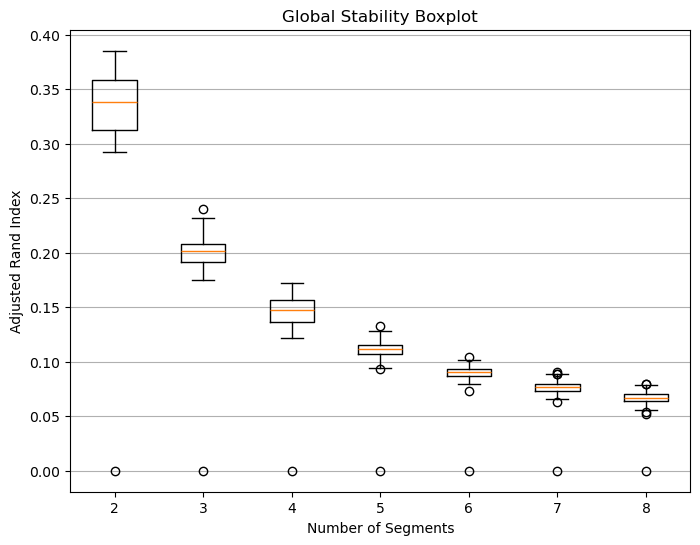

In [14]:
# Extract adjusted Rand index values for each number of segments
adjusted_rand_indices = [global_stability_results[n_segments] for n_segments in range(2, 9)]

# Create a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(adjusted_rand_indices)
plt.xlabel('Number of Segments')
plt.ylabel('Adjusted Rand Index')
plt.title('Global Stability Boxplot')
plt.xticks(ticks=np.arange(1, 8), labels=range(2, 9))
plt.grid(axis='y')
plt.show()


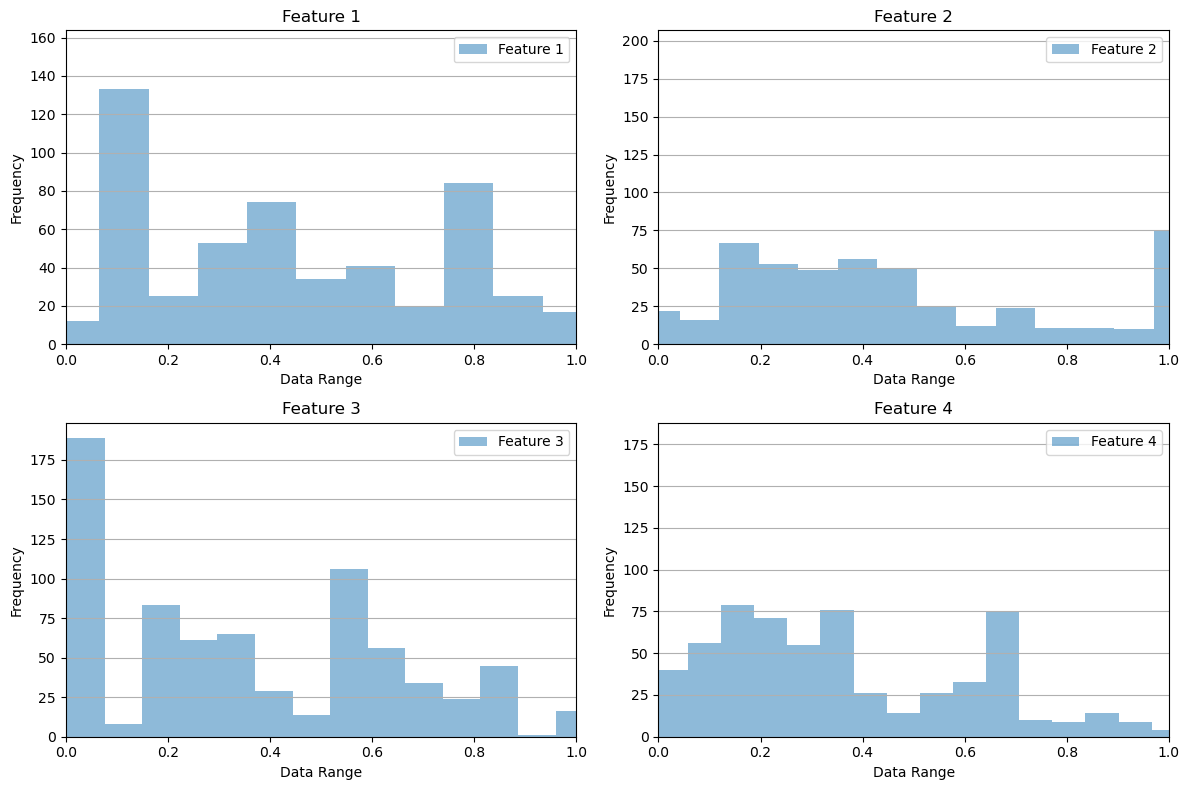

In [15]:
n_features = MD_pca.shape[1]  # Assuming each column represents a feature

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i in range(1, 5):
    axs[(i - 1) // 2, (i - 1) % 2].hist(MD_pca[:, i - 1], bins=30, alpha=0.5, label=f'Feature {i}')
    axs[(i - 1) // 2, (i - 1) % 2].set_xlabel('Data Range')
    axs[(i - 1) // 2, (i - 1) % 2].set_ylabel('Frequency')
    axs[(i - 1) // 2, (i - 1) % 2].set_title(f'Feature {i}')
    axs[(i - 1) // 2, (i - 1) % 2].legend()
    axs[(i - 1) // 2, (i - 1) % 2].set_xlim(0, 1)  # Set x-axis limits
    axs[(i - 1) // 2, (i - 1) % 2].grid(axis='y')

plt.tight_layout()
plt.show()

In [16]:
MD_k4 = MD_km28["4"]

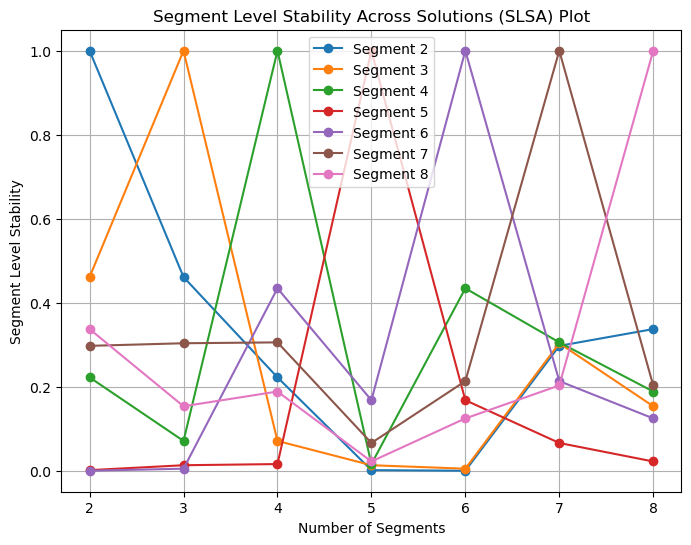

In [17]:
num_segments = range(2, 9)
segment_stability = []

# Calculate stability for each segment
for segment in num_segments:
    labels_segment = MD_km28[str(segment)].predict(MD_pca)
    segment_stability.append(labels_segment)

# Calculate segment-level stability
segment_level_stability = []
for i, segment_labels in enumerate(segment_stability):
    stability_scores = [
        np.mean(segment_labels == other_labels) for other_labels in segment_stability
    ]
    segment_level_stability.append(stability_scores)

plt.figure(figsize=(8, 6))

for i, segment in enumerate(num_segments):
    plt.plot(num_segments, segment_level_stability[i], marker='o', label=f'Segment {segment}')

plt.xlabel('Number of Segments')
plt.ylabel('Segment Level Stability')
plt.title('Segment Level Stability Across Solutions (SLSA) Plot')
plt.xticks(num_segments)
plt.legend()
plt.grid(True)

plt.show()

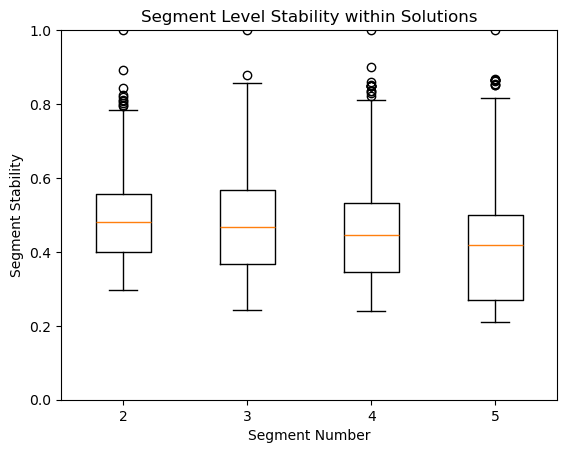

In [18]:
# Define segment solutions
segment_solutions = ["2", "3", "4", "5"]

# Store segment labels and similarities in dictionaries
segment_labels = {}
segment_similarities = {}

# Calculate segment labels and similarities for each solution
for segment in segment_solutions:
    segment_labels[segment] = MD_km28[segment].predict(MD_pca)
    segment_similarities[segment] = MD_km28[segment].transform(MD_pca).min(axis=1)

# Calculate and store normalized segment stability values
segment_stability_values = []
for segment in segment_solutions:
    similarities = segment_similarities[segment]
    normalized_similarities = similarities / np.max(similarities)
    segment_stability_values.append(normalized_similarities)


plt.boxplot(segment_stability_values, whis=1.5)
plt.xlabel("Segment Number")
plt.ylabel("Segment Stability")
plt.xticks(range(1, len(segment_solutions) + 1), segment_solutions)
plt.ylim(0, 1)
plt.title("Segment Level Stability within Solutions")

plt.show()


In [29]:
from sklearn.mixture import GaussianMixture

# Generate GMM models for different numbers of clusters (k = 2 to 8)
models = {}
for k in range(2, 9):
    gmm = GaussianMixture(n_components=k, covariance_type='full', n_init=10, random_state=1234)
    gmm.fit(MD_x) 
    models[k] = gmm

# Display information about the models
for k, model in models.items():
    print(f"Number of clusters: {k}")
    print(f"AIC: {model.aic(MD_x)}")
    print(f"BIC: {model.bic(MD_x)}")

Number of clusters: 2
AIC: -21985.641849663745
BIC: -21167.027071810353
Number of clusters: 3
AIC: -31471.10744759176
BIC: -30240.544587979883
Number of clusters: 4
AIC: -38371.92791555408
BIC: -36729.41697418372
Number of clusters: 5
AIC: -43931.56250144559
BIC: -41877.10347831675
Number of clusters: 6
AIC: -56110.08402145092
BIC: -53643.6769165636
Number of clusters: 7
AIC: -48466.415811438375
BIC: -45588.060624792575
Number of clusters: 8
AIC: -58522.03485291833
BIC: -55231.73158451405


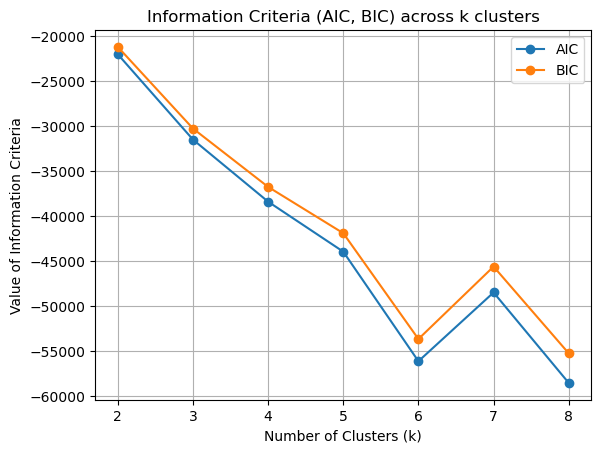

In [30]:
aic_values = [model.aic(MD_x) for k, model in models.items()]
bic_values = [model.bic(MD_x) for k, model in models.items()]

# Plotting AIC, BIC, ICL
plt.plot(range(2, 9), aic_values,marker='o', label='AIC')
plt.plot(range(2, 9), bic_values,marker='o', label='BIC')

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Value of Information Criteria')
plt.title('Information Criteria (AIC, BIC) across k clusters')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
from sklearn.metrics.cluster import contingency_matrix
gmm_with_kmeans_clusters = GaussianMixture(n_components=4, covariance_type='full', n_init=10, random_state=1234)
gmm_with_kmeans_clusters.fit(MD_x) 
gmm_kmeans_clusters = gmm_with_kmeans_clusters.predict(MD_x)  

# Display the contingency table between KMeans and GMM with KMeans clusters
contingency_table_kmeans_gmm = contingency_matrix(kmeans_clusters, gmm_kmeans_clusters)
print("Contingency Table (KMeans vs. GMM with KMeans clusters):\n", contingency_table_kmeans_gmm)

Contingency Table (KMeans vs. GMM with KMeans clusters):
 [[ 29  50 268  17]
 [ 28 188   0  24]
 [152   0 362  19]
 [123   0   0 193]]


In [48]:
gmm_m4a = GaussianMixture(n_components=4)
gmm_m4a.fit(MD_x)

log_m4a = gmm_m4a.score(MD_x)

gmm_m4 = GaussianMixture(n_components=4)
gmm_m4.fit(MD_x)

log_m4 = gmm_m4.score(MD_x)

print("Log-likelihood for MD.m4a:", log_m4a)
print("Log-likelihood for MD.m4:", log_m4)

Log-likelihood for MD.m4a: 13.892533551048547
Log-likelihood for MD.m4: 11.068744792060572


In [52]:
like_count = pd.value_counts(dt['Like'])
dt_reversed = like_count.iloc[::-1]

print(dt_reversed)

Like
-1               58
-2               59
-4               71
-3               73
I love it!+5    143
I hate it!-5    152
+1              152
+4              160
0               169
+2              187
+3              229
Name: count, dtype: int64


C:\Users\soumi\AppData\Local\Temp\ipykernel_18820\2020141755.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  like_count = pd.value_counts(dt['Like'])


In [53]:
like_mapping = {
    'I HATE IT!-5': -5,
    '-4': -4,
    '-3': -3,
    '-2': -2,
    '-1': -1,
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    'I LOVE IT!+5': 5
}

dt['Like.n'] = dt['Like'].map(like_mapping)
ln_count = dt['Like.n'].value_counts()
print(ln_count)

Like.n
 0.0    169
-3.0     73
-4.0     71
-2.0     59
-1.0     58
Name: count, dtype: int64


In [58]:
independent_vars = dt.columns[0:11] 
form_str = ' + '.join(independent_vars)
form_str = 'Like ~ ' + form_str

f = dmatrices(form_str, data=dt)[1]
print(f)

[[1. 0. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 0. 0.]
 [1. 0. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 1. 0. 1.]]


In [62]:
np.random.seed(1234)

X = dmatrix(f.design_info, data=dt)
y = dmatrix('Like', data=dt)

n_components = 2
n_init = 10
verbose = False
n_rep=10

model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=verbose)
MD_reg2 = model.fit(X, y)

print(MD_reg2)
cluster_sizes = np.bincount(model.predict(X))

print("Cluster sizes:")
for i, size in enumerate(cluster_sizes):
    print(f"{i+1}: {size}")

GaussianMixture(n_components=2, n_init=10, verbose=False)
Cluster sizes:
1: 985
2: 468


### Profiling Segments

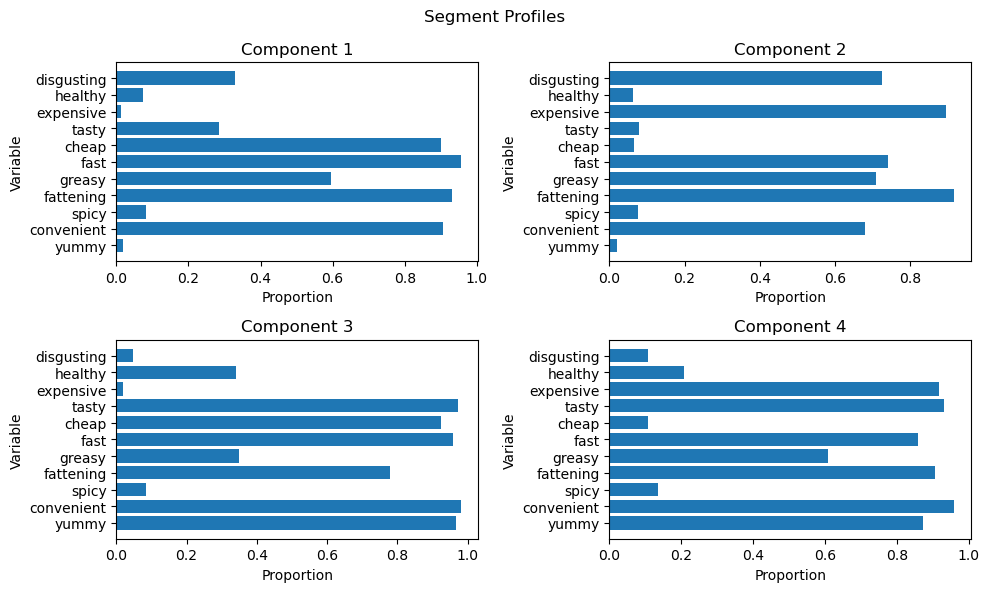

In [65]:
# Extracting labels from the kmeans clustering model
kmeans = MD_km28['4']
labels = kmeans.labels_

# Grouping by labels and computing mean
MD_mean = MD_x.groupby(labels).mean()

# Creating subplots for each component
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# Loop through each component and plot
for i, ax in enumerate(axs.flat):
    ax.barh(range(MD_mean.shape[1]), MD_mean.iloc[i])
    ax.set_title(f'Component {i+1}')
    ax.set(ylabel='Variable', xlabel='Proportion')
    ax.set_yticks(range(MD_mean.shape[1]))
    ax.set_yticklabels(MD_x.columns)

# Adjusting layout
fig.suptitle('Segment Profiles')
fig.tight_layout()

plt.show()

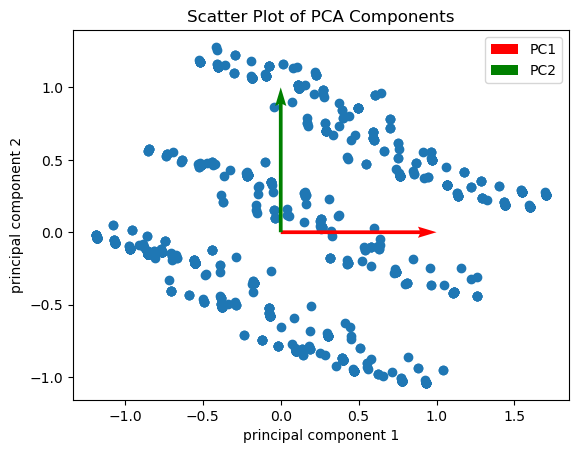

In [66]:
# Create a scatter plot of MD_pca (assuming it has two components)
plt.scatter(MD_pca[:, 0], MD_pca[:, 1])
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.title('Scatter Plot of PCA Components')

# Show the principal component axes
plt.quiver(0, 0, 1, 0, angles='xy', scale_units='xy', scale=1, color='r', label='PC1')
plt.quiver(0, 0, 0, 1, angles='xy', scale_units='xy', scale=1, color='g', label='PC2')
plt.legend()

plt.show()

### Describing Segments

D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


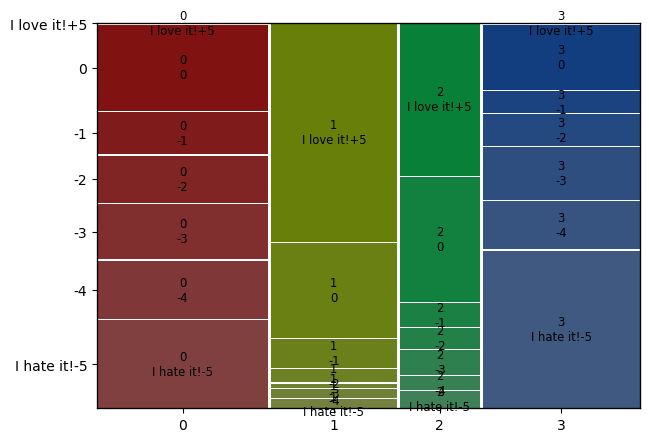

In [77]:
def label_encoding(column, data):
    data[column] = LabelEncoder().fit_transform(data[column])
    return data

# List of categorical columns
cat_columns = ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
               'tasty', 'expensive', 'healthy', 'disgusting']

# Applying label encoding to categorical columns
for col in cat_columns:
    label_encoding(col, dt)

# Selecting the categorical columns
df_eleven = dt.loc[:, cat_columns]

# KMeans clustering with 4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(df_eleven)

# Assigning cluster labels to the data
dt['cluster_num'] = kmeans.labels_
crosstab = pd.crosstab(dt['cluster_num'], dt['Like'])

crosstab = crosstab.reindex(columns=['I hate it!-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', 'I love it!+5'])

plt.rcParams['figure.figsize'] = (7, 5)
mosaic(crosstab.stack())
plt.show()

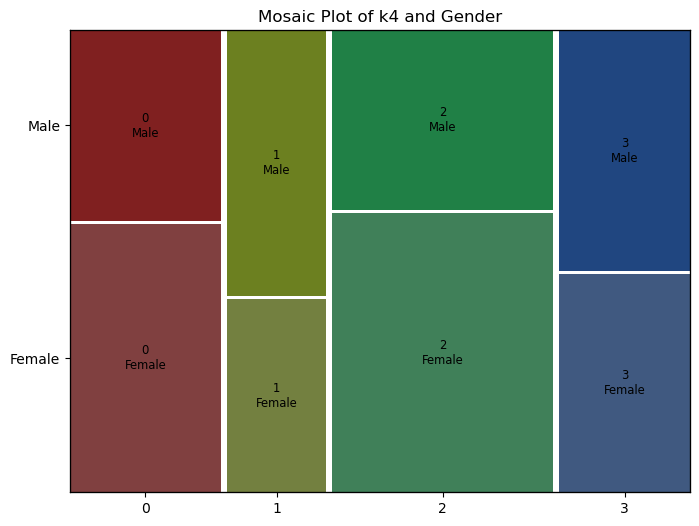

In [79]:
MD_k4=MD_km28['4']
k4 = MD_k4.labels_
crosstab = pd.crosstab(k4, dt['Gender'])

# Plotting the mosaic plot
plt.rcParams['figure.figsize'] = (8, 6)
mosaic(crosstab.stack(), title='Mosaic Plot of k4 and Gender', gap=0.01)
plt.show()

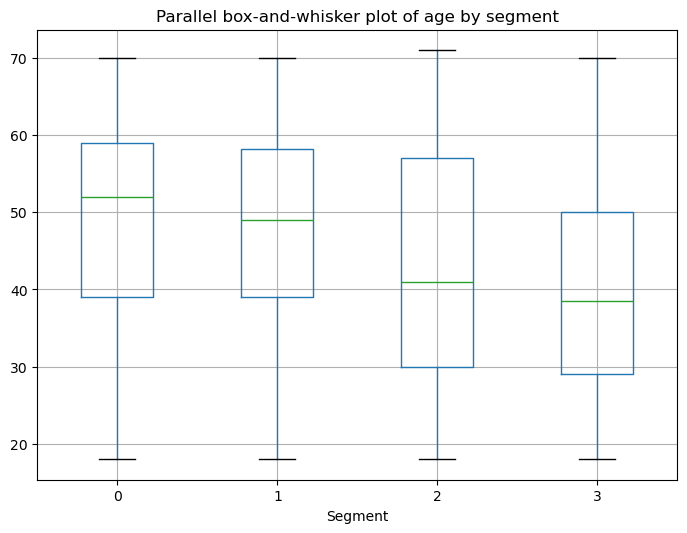

In [80]:
dataframe = pd.DataFrame({'Segment': k4, 'Age': dt['Age']})

dataframe.boxplot(by='Segment', column='Age')
plt.title('Parallel box-and-whisker plot of age by segment')
plt.suptitle('')
plt.show()

In [88]:
dt['VisitFrequency'] = LabelEncoder().fit_transform(dt['VisitFrequency'])
visitf = dt.groupby('cluster_num')['VisitFrequency'].mean()
visitf = visitf.to_frame().reset_index()
print(visitf)

   cluster_num  VisitFrequency
0            0        2.809061
1            1        2.584483
2            2        2.540123
3            3        2.679167


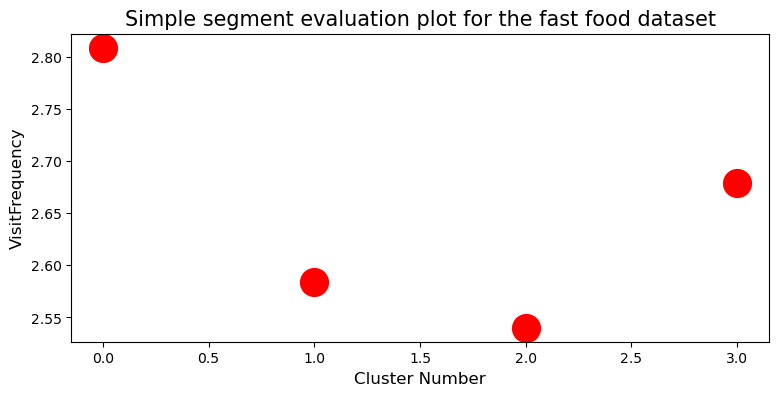

In [91]:
plt.figure(figsize=(9, 4))
plt.scatter(x=visitf.index, y=visitf['VisitFrequency'], s=400, color='r')
plt.title('Simple segment evaluation plot for the fast food dataset', fontsize=15)
plt.xlabel('Cluster Number', fontsize=12)
plt.ylabel('VisitFrequency', fontsize=12)
plt.show()